# WHAT DOES MY BAND LIKE TO SING ABOUT?

In [1]:
import pandas as pd
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
import os
from os.path import join as pjoin
import numpy as np
import pandas as pd
from time import time, sleep, strftime, localtime
from datetime import datetime

%reload_ext autoreload
%autoreload 1

pd.set_option('display.max_rows', 800)
pd.set_option('display.max_columns', 30)
pd.set_option('display.width', 100)
pd.set_option('display.max_colwidth', 100)

display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

In [2]:
import re, string
import requests
from bs4 import BeautifulSoup
from itertools import groupby
from Utils.DataUtils import *

In [3]:
all_songs_df = pd.read_csv("./ironmaiden.csv")
df_band_albums = pd.read_csv("./df_band_albums.csv")

In [4]:
discography_df = pd.merge(left=df_band_albums[["title", "year", "is_single"]], right=all_songs_df,left_on="title", right_on="album_name", how="inner")
discography_df.drop("album_name", axis=1, inplace=True)
display(
    discography_df.shape,
    discography_df.head()
)

(186, 5)

,title,year,is_single,song_name,song_lyrics
0,Iron Maiden,1980,False,'Prowler',"Walking through the city, looking oh so pretty\nI've just got to find my way\nSee the ladies fla..."
1,Iron Maiden,1980,False,'Sanctuary',Out of winter came a warhorse of steel\nI've never killed a woman before\nBut I know how it feel...
2,Iron Maiden,1980,False,'Remember Tomorrow',"Unchain the colours before my eyes,\nYesterday's sorrows, tomorrow's white lies.\nScan the horiz..."
3,Iron Maiden,1980,False,'Running Free',"Just sixteen, a pickup truck, out of money, out of luck.\nI've got nowhere to call my own, hit t..."
4,Iron Maiden,1980,False,'Phantom Of The Opera',I've been looking so long for you now you won't get away from my grasp\nYou've been living so lo...


In [5]:
analyse_nans(discography_df)

,title,year,is_single,song_name,song_lyrics
total,0,0,0,0,0
percentage,0,0,0,0,0
idx_list,[],[],[],[],[]


# Drop the Nans

In [6]:
discography_df.dropna(inplace=True, axis=0)

#  Combine the songs for each album

In [7]:
q = "(is_single==False)"
album_df = discography_df.query(q)[["title", "year", "song_lyrics"]]
album_df["song_lyrics"] = discography_df.query(q).groupby(["title", "year"])['song_lyrics'].transform(lambda x: ' '.join(x))
album_df.drop_duplicates(inplace=True)
album_df

,title,year,song_lyrics
0,Iron Maiden,1980,"Walking through the city, looking oh so pretty\nI've just got to find my way\nSee the ladies fla..."
8,Killers,1981,"I was born into a scene of angriness and greed, and dominance and persecution.\nMy mother was a ..."
17,The Number Of The Beast,1982,Longboats have been sighted the evidence of war has begun\nMany Nordic fighting men their swords...
26,Piece Of Mind,1983,"It's snowing outside the rumbling sound\nof engines roar in the night,\nThe mission is near the ..."
35,Powerslave,1984,There goes the siren that warns of the air raid\nThen comes the sound of the guns sending flak\n...
42,Somewhere In Time,1986,If you had the time to lose\nAn open mind and time to choose\nWould you care to take a look\nOr ...
50,Seventh Son Of A Seventh Son,1988,Seven deadly sins\nSeven ways to win\nSeven holy paths to hell\nAnd your trip begins\n\nSeven do...
58,No Prayer For The Dying,1990,Trace your way back 50 years\nTo the Glow of Dresden - blood and tears\nIn the black above by th...
68,Fear Of The Dark,1992,Covered in sinners and dripping with guilt\nMaking your money from slime and from filth\nParadin...
85,The XFactor,1995,Eleven saintly shrouded men\nSilhouettes stand against the sky\nOne in front with a cross held h...


# Cleaning 

In [8]:
# Remove all the escape delimiters in the lyrics
album_df["song_lyrics"] = album_df["song_lyrics"].apply(lambda s: re.sub("[\n\t\r]", ' ', s))

In [9]:
# What all special characters exist in the lyrics? 
unique_characters = list(set(''.join(album_df["song_lyrics"].apply(lambda s: re.sub("[\w]", '', s)).values.ravel()[0])))
print("these are the non-alphanumeric unique characters - ", unique_characters)
# Keep only the alphabets, remove numeric characters
album_df["song_lyrics"] = album_df["song_lyrics"].apply(lambda s: re.sub("[^a-zA-Z]", ' ', s))

these are the non-alphanumeric unique characters -  ['?', ' ', "'", '[', '"', '.', ']', ',']


In [10]:
# What all special characters exist in the lyrics? 
unique_characters = list(set(''.join(album_df["song_lyrics"].apply(lambda s: re.sub("[\w]", '', s)).values.ravel()[0])))
unique_characters

[' ']

# Lower case  

In [11]:
album_df["song_lyrics"] = album_df["song_lyrics"].apply(str.lower)

# WordClouds 

In [31]:
from wordcloud import WordCloud
from sklearn.feature_extraction import text 


wc = WordCloud(stopwords=text.ENGLISH_STOP_WORDS, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

In [32]:
album_df.reset_index(drop=True, inplace=True)
# album_df

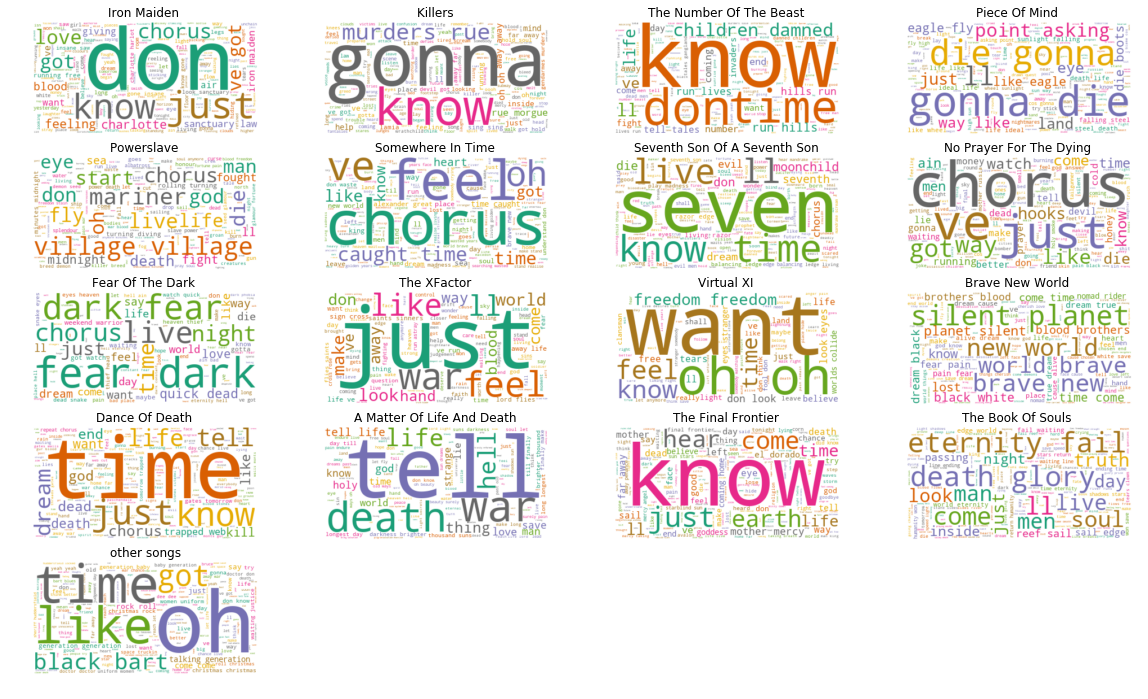

In [34]:
# Reset the output dimensions
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [20, 12]

albums = album_df["title"]

# Create subplots for each album
for idx, album in zip(album_df.index, albums):
    q = "title==\""+album+"\""
    wc.generate(album_df.query(q)["song_lyrics"].values[0])
    
    plt.subplot(5, 4, idx+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(album)
    
plt.show()

---------

# Tokenize  

In [12]:
# We are going to create a document-term matrix using CountVectorizer, and exclude common English stop words
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words='english')
data_cv = cv.fit_transform(album_df["song_lyrics"])

In [13]:
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm.index = album_df["title"]
data_dtm.head()

,abandoned,abates,abide,ablaze,able,aboard,absolution,abuse,abused,abyss,acacia,accept,accompany,according,accursed,...,yearning,years,yeeeeaaaaaaaahhhh,yellow,yes,yesterday,yield,yoke,yorkshire,young,youth,yowsa,zeal,zero,zone
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Iron Maiden,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0
Killers,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1
The Number Of The Beast,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
Piece Of Mind,0,0,0,2,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,1,0,0,0,0,0
Powerslave,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [14]:
# dtm_filename = "iron_maiden_dtm.pkl"
# save_to_disk(data_dtm, dtm_filename)

----------------

In [15]:
# data = load_from_disk(dtm_filename)
# data.shape